### Libraries

In [20]:
import cv2 as cv
import time
from IPython.display import Image, display
import matplotlib.pyplot as plt
import numpy as np
from functions import * 

### **(Memory and Color)** Load a photo into open CV and:
##### Change the green and blue channels.

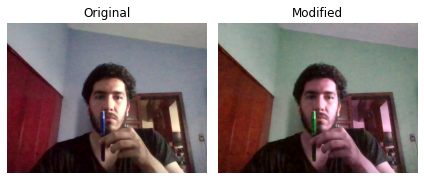

In [2]:
frame = cv.imread("images/selfie.jpg")

b,g,r = cv.split(frame)
mod_frame = cv.merge((g,b,r))

plot_img(2,(6,3),["Original", "Modified"],[frame, mod_frame])

##### Convert the original image into gray scale.


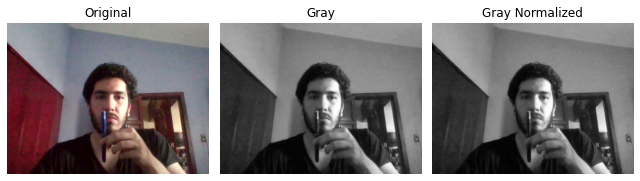

In [3]:
gray = cv.cvtColor(frame, cv.COLOR_BGR2GRAY)
gray.astype(float)
grayN = cv.normalize(gray, None, 0, 255, cv.NORM_MINMAX, cv.CV_8U)

plot_img(3,(9,4.5),["Original", "Gray", "Gray Normalized"],[frame, gray, grayN])

##### Convert the original image into HSV.

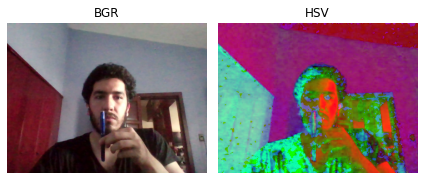

In [4]:
hsv = cv.cvtColor(frame, cv.COLOR_BGR2HSV)
plot_img(2,(6,3),["BGR", "HSV"],[frame, hsv])

### **(Capture)** Use a video capture to:
Estimate the f number of your camera.

Use a reference object and measure at know distance, count the number of pixels to estimate the f number.

In [5]:
# The previous image of me holding a pen was taking 50 cm away from the object (pen), and the length of the 
# pen in the picture is 161 px, while the real length is 14.5 cm. Therefore we can calculate the focal length as:
F = (161 * 50) / 14
print(f"The focal length of my camera is {F}") 

The focal length of my camera is 575.0


#### Use the estimate f number to measure the distance to a second reference object.
Repeat the experiment at least using thee different distances. Report the measurement error.


In [6]:
### Now I will estimate the distance three times to another object (a notebook with 17.9 cm of height)
for i in range(3):
    _ = take_pic(2,f"images/notebook_{i+1}.jpg",False)
    time.sleep(15) # To give me time to measure a new distance

Taking picture in 2 seconds...
Image saved at images/notebook_1.jpg
Taking picture in 2 seconds...
Image saved at images/notebook_2.jpg
Taking picture in 2 seconds...
Image saved at images/notebook_3.jpg


In [7]:
real_distances = [50, 70, 90] # in cm
px_distances = [187, 143, 110] # in px
estim_distances = [(17.9 * F) / x for x in px_distances]
perc_error = [(abs(real - estim) / real) * 100 for real, estim in zip(real_distances, estim_distances)]

print(f"The estimated distances in cm were: {', '.join([f'{dist:.2f}' for dist in estim_distances])} and the average percentage error was: {np.mean(perc_error):.2f}%")

The estimated distances in cm were: 55.04, 71.98, 93.57 and the average percentage error was: 5.62%


### **(Enhancing)** Use a reference image to:
Do histogram equalization.

Apply equalization independently to all channels.


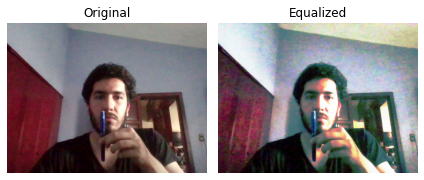

In [8]:
channels = b, g, r # from previous image of me holding a pen

eq_channels = [cv.equalizeHist(channel) for channel in channels]
eq_image = cv.merge(eq_channels)

plot_img(2,(6,3),["Original", "Equalized"],[frame, eq_image])

Apply equalization to the V channel on the HSV converted image. 

Once the V channel has been equalized convert back to RGB and display the image

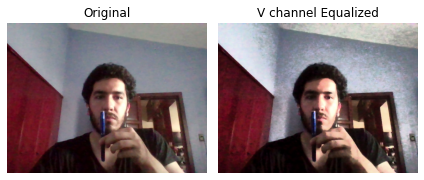

In [9]:
h,s,v = cv.split(hsv)
eq_v = cv.equalizeHist(v)
hsv_mod = cv.merge([h,s,eq_v])
brg_mod = cv.cvtColor(hsv_mod, cv.COLOR_HSV2BGR)

plot_img(2,(6,3),["Original", "V channel Equalized"],[frame, brg_mod])

Apply the gamma enhancing:

Enhance the low intensity areas.

Enhance the high intensity areas.

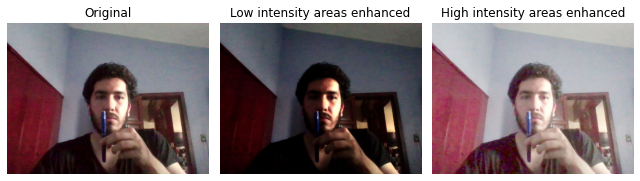

In [10]:
plot_img(3,(9,4.5),["Original", "Low intensity areas enhanced", "High intensity areas enhanced"],[frame, adjust_gamma(frame,0.5), adjust_gamma(frame,2)])

### **(Sampling)** Use your own image.
Do the pyramid representation:

Down sample the image to 2,4,8,16.
- Nearest neighbor


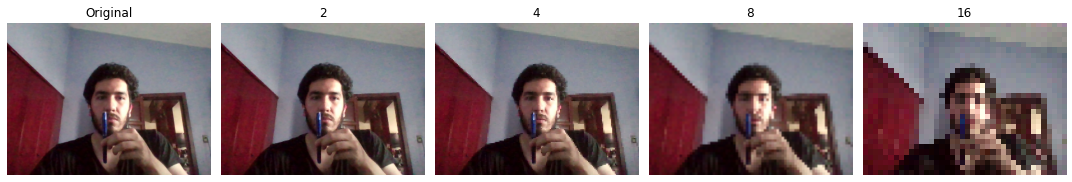

In [52]:
factors = [2, 4, 8, 16]

nn_imgs = []
for factor in factors:
    resample = cv.resize(frame, (frame.shape[1] // factor, frame.shape[0] // factor), interpolation=cv.INTER_NEAREST)
    nn_imgs.append(resample)

plot_img(5,(15,7.5),["Original", "2", "4", "8", "16"],[frame, nn_imgs[0], nn_imgs[1], nn_imgs[2], nn_imgs[3]])


- Bilinear filtering

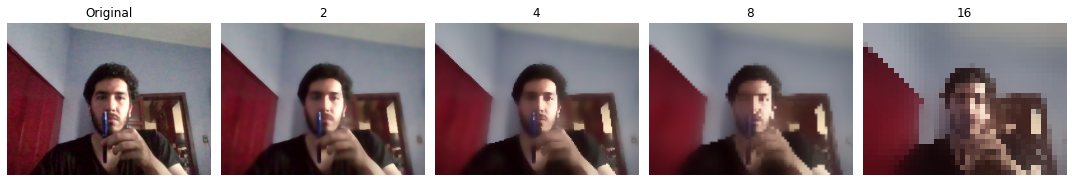

True

In [56]:
bf_imgs = []

for i, factor in enumerate(factors):
    resample = nn_imgs[i]
    filtered = cv.bilateralFilter(resample,9,120,120)
    bf_imgs.append(filtered)

plot_img(5,(15,7.5),["Original", "2", "4", "8", "16"],[frame, bf_imgs[0], bf_imgs[1], bf_imgs[2], bf_imgs[3]])


- Max pooling filtering

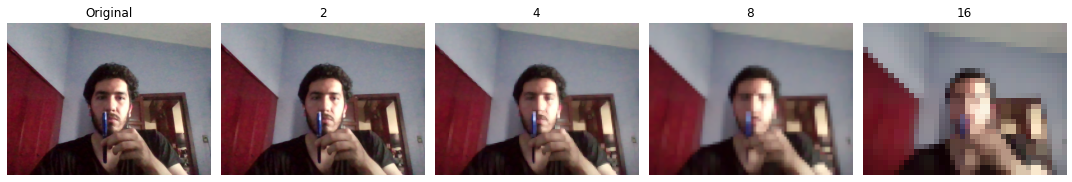

In [57]:
max_pool_images = []

for factor in factors:
    small_img = cv.resize(frame, (frame.shape[1] // factor, frame.shape[0] // factor), interpolation=cv.INTER_AREA)
    pooled_img = cv.dilate(small_img, np.ones((2,2), np.uint8))
    max_pool_images.append(pooled_img)

plot_img(5,(15,7.5),["Original", "2", "4", "8", "16"],[frame, max_pool_images[0], max_pool_images[1], max_pool_images[2], max_pool_images[3]])

for idx, imagen in enumerate(max_pool_images):
    nombre_archivo = f'foto_{idx+1}.jpg'  
    cv.imwrite(nombre_archivo, imagen)

Use the 1/16 representation and up sample to the original size: 

- Bilinar interpolation

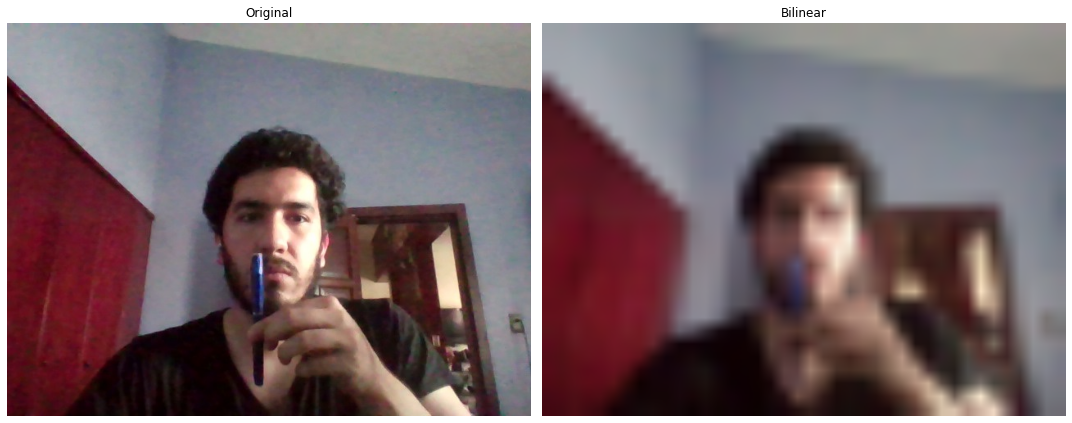

In [58]:
downsampled_img = cv.resize(frame, (frame.shape[1] // 16, frame.shape[0] // 16), interpolation=cv.INTER_AREA)
upsampled_bilinear = cv.resize(downsampled_img, (frame.shape[1], frame.shape[0]), interpolation=cv.INTER_LINEAR)

plot_img(2,(15,7.5),["Original", "Bilinear"],[frame, upsampled_bilinear])


- SINC interpolation

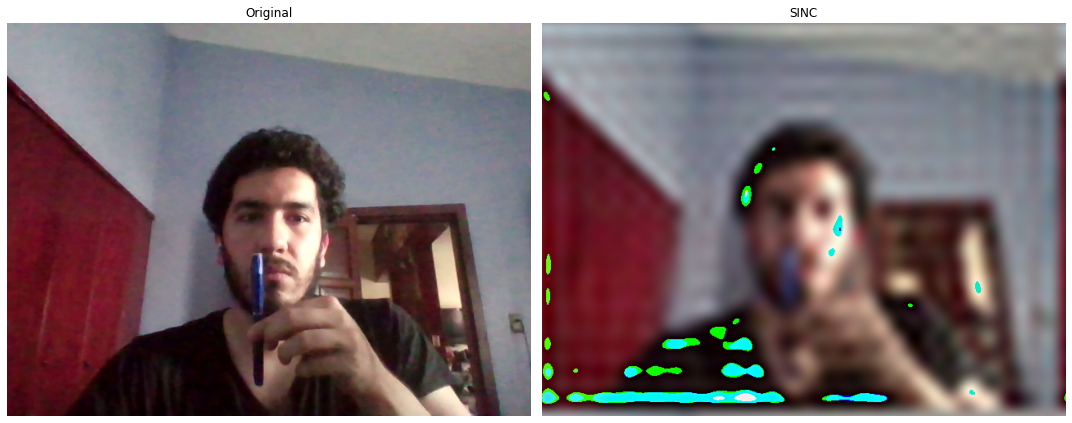

In [65]:
from scipy.signal import resample

def sinc_interpolation(image, new_shape):
    l, a = image.shape[:2]
    new_l, new_a = new_shape[:2]
    
    resampled_rows = np.zeros((new_l, a, 3))
    for i in range(3): 
        resampled_rows[:, :, i] = resample(image[:, :, i], new_l, axis=0)
    
    resampled_image = np.zeros((new_l, new_a, 3))
    for i in range(3): 
        resampled_image[:, :, i] = resample(resampled_rows[:, :, i], new_a, axis=1)
    
    return resampled_image.astype('uint8')

l,a = frame.shape[:2]   
downsampled_img = cv.resize(frame, (frame.shape[1] // 16, frame.shape[0] // 16), interpolation=cv.INTER_AREA)
sinc_upsampled = sinc_interpolation(downsampled_img, (l,a))


plot_img(2,(15,7.5),["Original", "SINC"],[frame, sinc_upsampled])


### **(Filtering)** Use your own image:


- Gaussian Noise (mean,median,anisotropic)

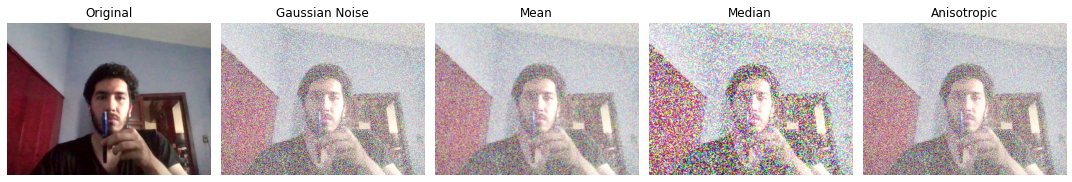

In [59]:
gauss = np.random.normal(0, 25, frame.shape).astype('uint8')
gaussian_noisy_image = cv.add(frame, gauss)
mean_filtered_image = cv.blur(gaussian_noisy_image, (3, 3))
median_filtered_image = cv.medianBlur(gaussian_noisy_image, 3)
anisotropic_filtered_image = cv.edgePreservingFilter(gaussian_noisy_image, flags=1, sigma_s=60, sigma_r=0.4)

plot_img(5,(15,7.5),["Original", "Gaussian Noise", "Mean", "Median", "Anisotropic"],[frame, gaussian_noisy_image,mean_filtered_image,median_filtered_image,anisotropic_filtered_image])

- Salt and Pepper Noise (mean,median,anisotropic)

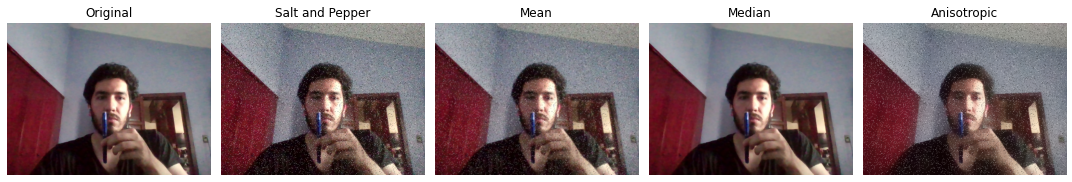

In [60]:
salt_pepper_noisy_image = np.copy(frame)
# Salt noise
coords = [np.random.randint(0, i - 1, int(np.ceil(0.01 * frame.size))) for i in frame.shape]
salt_pepper_noisy_image[coords[0], coords[1]] = 255
# Pepper noise
coords = [np.random.randint(0, i - 1, int(np.ceil(0.01 * frame.size))) for i in frame.shape]
salt_pepper_noisy_image[coords[0], coords[1]] = 0

mean_filtered_images = cv.blur(salt_pepper_noisy_image, (3, 3))
median_filtered_images = cv.medianBlur(salt_pepper_noisy_image, 3)
anisotropic_filtered_images = cv.edgePreservingFilter(salt_pepper_noisy_image, flags=1, sigma_s=60, sigma_r=0.4)

plot_img(5,(15,7.5),["Original", "Salt and Pepper", "Mean", "Median", "Anisotropic"],[frame, salt_pepper_noisy_image,mean_filtered_images,median_filtered_images,anisotropic_filtered_images])


- Laplacian, Sobel X, Laplacian of Gaussian, Sharpening

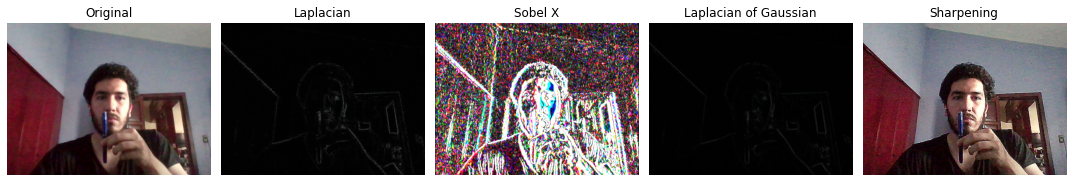

In [61]:
laplacian_filtered_image = cv.Laplacian(frame, cv.CV_64F)
sobel_x_filtered_image = cv.Sobel(frame, cv.CV_64F, 1, 0, ksize=5)
laplacian_gauss_filtered_image = cv.Laplacian(cv.GaussianBlur(frame, (3, 3), 0), cv.CV_64F)
sharpening_kernel = np.array([[-1, -1, -1], [-1, 9,-1], [-1, -1,-1]])
sharpened_image = cv.filter2D(frame, -1, sharpening_kernel)

laplacian_filtered_image_8u = cv.convertScaleAbs(laplacian_filtered_image)
sobel_x_filtered_image_8u = cv.convertScaleAbs(sobel_x_filtered_image)
laplacian_gauss_filtered_image_8u = cv.convertScaleAbs(laplacian_gauss_filtered_image)

plot_img(5, (15, 7.5), ["Original", "Laplacian", "Sobel X", "Laplacian of Gaussian", "Sharpening"], [frame, laplacian_filtered_image_8u, sobel_x_filtered_image_8u, laplacian_gauss_filtered_image_8u, sharpened_image])

#### Investigate Homomorphic filter (https://en.wikipedia.org/wiki/Homomorphic_filtering Links to an external site.)
    Implement using only convolutions.
    Implement it on the Fourier domain.


Homomorphic filter: used to simultaneously normalize brightness across an image and enhance its contrast. It operates by applying a high-pass filter in the logarithmic domain
<ol>
    <li>Transform the image into the logarithmic domain.</li>
    <li>Apply a high-pass filter to the Fourier transform of the logarithmic image.</li>
    <li>Transform the result back to the spatial domain and exponentiate.</li>
<ol>

In [21]:

gray_image = cv.imread("images/selfie.jpg", cv.IMREAD_GRAYSCALE)

gaussian_kernel = cv2.getGaussianKernel(ksize=51, sigma=10)
gaussian_kernel = gaussian_kernel * gaussian_kernel.T

illumination = cv2.filter2D(gray_image, -1, gaussian_kernel)

reflectance = gray_image - illumination

scaled_illumination = cv2.normalize(illumination, None, alpha=0.7, beta=1.2, norm_type=cv2.NORM_MINMAX)
scaled_reflectance = cv2.normalize(reflectance, None, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX)

filtered_image_spatial = cv2.normalize(scaled_illumination + scaled_reflectance, None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX)

In [22]:

gray_image = cv.imread("images/selfie.jpg", cv.IMREAD_GRAYSCALE)

image_log = np.log1p(np.array(gray_image, dtype="float"))

f = np.fft.fft2(image_log)
fshift = np.fft.fftshift(f)

rows, cols = gray_image.shape
crow, ccol = int(rows / 2), int(cols / 2)  

r = 30  
center = [crow, ccol]
x, y = np.ogrid[:rows, :cols]
mask = np.ones((rows, cols), np.uint8)

mask_area = np.logical_and(
    ((x - center[0]) ** 2 + (y - center[1]) ** 2 >= r ** 2),
    ((x - center[0]) ** 2 + (y - center[1]) ** 2 <= (r + 50) ** 2)
)
mask[mask_area] = 0

fshift = fshift * mask

f_ishift = np.fft.ifftshift(fshift)
f_i = np.fft.ifft2(f_ishift)

image_i = np.exp(np.real(f_i)) - 1

image_i = np.clip(image_i, 0, 255)
image_i = np.array(image_i, dtype="uint8")

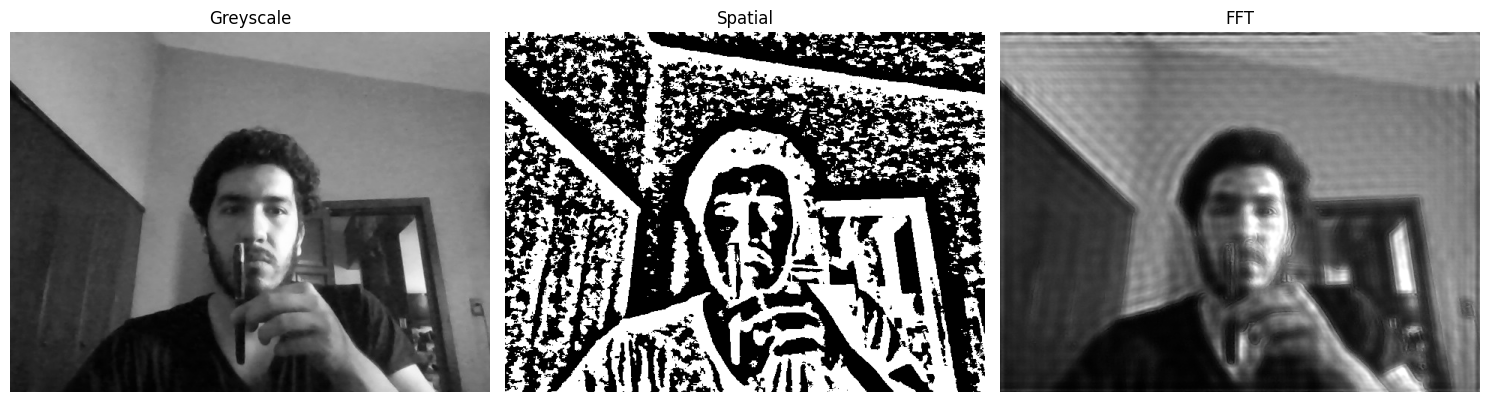

In [23]:
plot_img(3,(15,6),["Greyscale", "Spatial", "FFT"],[gray_image, filtered_image_spatial, image_i])

#### Implement and test your own versions of the
    IIR filter

General case:

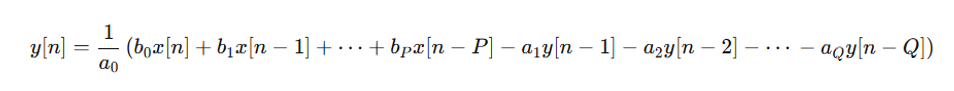

With case:

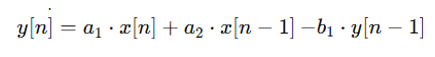

    FIR filter
General case:

    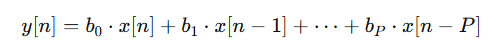
    

In [28]:
import numpy as np
import cv2 as cv

video_path = '/mnt/d/sharegit/CompVis/HW1/VideoTest.mp4' 
cap = cv.VideoCapture(video_path)

if not cap.isOpened():
    print("Cannot open video file")
    exit()

ret, frame = cap.read()
if not ret:
    print("Can't receive frame (stream end?). Exiting ...")
    exit()

gray2 = frame[:, :, 0].astype(float)
frame_v4 = gray2.copy()
frame_v3 = gray2.copy()
frame_v2 = gray2.copy()
frame_v1 = gray2.copy()

alpha = 0.1  

while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        print("Can't receive frame (stream end?). Exiting ...")
        break

    gray = cv.cvtColor(frame, cv.COLOR_BGR2GRAY).astype(float)
    grayN = cv.normalize(gray, None, 0, 255, cv.NORM_MINMAX, cv.CV_8U)
    cv.imshow('Gray', grayN)

    gray2 = gray * alpha + gray2 * (1.0 - alpha)
    img_iir = cv.normalize(gray2, None, 0, 255, cv.NORM_MINMAX, cv.CV_8U)
    cv.imshow('IIR', img_iir)

    FIRimg = (frame_v4 + frame_v3 + frame_v2 + frame_v1 + gray) / 5.0
    img_fir = cv.normalize(FIRimg, None, 0, 255, cv.NORM_MINMAX, cv.CV_8U)
    cv.imshow('FIR', img_fir)

    frame_v4 = frame_v3
    frame_v3 = frame_v2
    frame_v2 = frame_v1
    frame_v1 = gray

    if cv.waitKey(1) == ord('q'):
        break

cap.release()
cv.destroyAllWindows()

Can't receive frame (stream end?). Exiting ...


### **(Edge Detection)** Use your own image.

#### Compute the image gradient of the grayscale image.
    Show your result as an RGB
        Red channel the Gradient Magnitude
        Blue channel the gradient angle
        Green channel the gray scale image

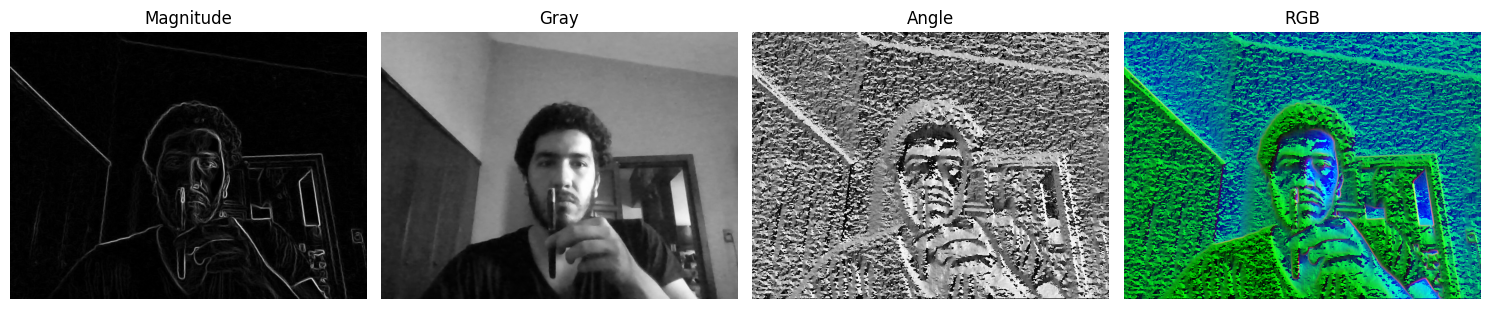

In [25]:
gray_image = cv.imread("images/selfie.jpg", cv.IMREAD_GRAYSCALE)

grad_x = cv.Sobel(gray_image, cv.CV_64F, 1, 0, ksize=3)
grad_y = cv.Sobel(gray_image, cv.CV_64F, 0, 1, ksize=3)

magnitude = cv.magnitude(grad_x, grad_y)
angle = cv.phase(grad_x, grad_y, angleInDegrees=True)

magnitude = cv.normalize(magnitude, None, 0, 255, cv.NORM_MINMAX)
angle = cv.normalize(angle, None, 0, 255, cv.NORM_MINMAX)

magnitude = magnitude.astype(np.uint8)
angle = angle.astype(np.uint8)

rgb_image = cv.merge([gray_image, angle, magnitude])

plot_img(4,(15,6),["Magnitude", "Gray", "Angle", "RGB"],[magnitude, gray_image, angle, rgb_image])

#### Using the zero-crossing property of the Laplacian:
    Show the localization of the edges of the previous image.

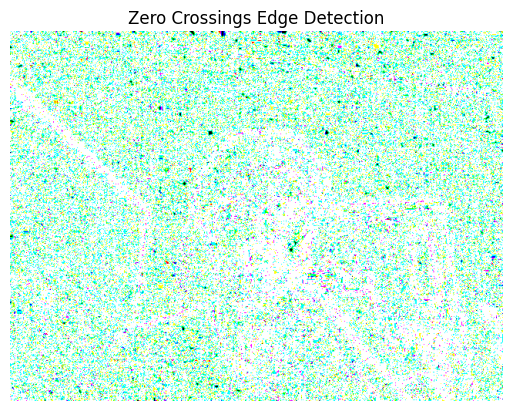

In [26]:
import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt

gray_image = rgb_image

LoG = cv.Laplacian(gray_image, cv.CV_64F)

minLoG = cv.morphologyEx(LoG, cv.MORPH_ERODE, np.ones((3, 3)))
maxLoG = cv.morphologyEx(LoG, cv.MORPH_DILATE, np.ones((3, 3)))

zeroCross = np.logical_or(
    np.logical_and(minLoG < 0, LoG > 0), 
    np.logical_and(maxLoG > 0, LoG < 0)
).astype(np.uint8)

zeroCross_normalized = cv.normalize(zeroCross, None, 0, 255, cv.NORM_MINMAX, cv.CV_8U)

plt.imshow(zeroCross_normalized, cmap='gray')
plt.title('Zero Crossings Edge Detection')
plt.axis('off')
plt.show()


####    Compute the Canny edges:
    Use at least three different values of sigma.

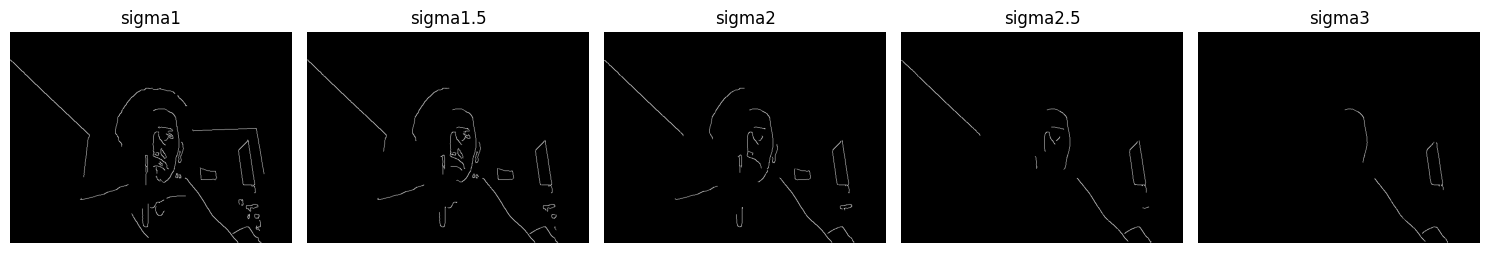

In [27]:
gray_image = cv.imread("images/selfie.jpg", cv.IMREAD_GRAYSCALE)
sigma_values = [1, 1.5, 2, 2.5, 3]
canny_edges = []

for sigma in sigma_values:
    blurred_image = cv.GaussianBlur(gray_image, (0, 0), sigma)
    edges = cv.Canny(blurred_image, 100, 200)  # You can adjust the thresholds (100, 200) as needed
    canny_edges.append(edges)

plot_img(len(canny_edges),(15,6),["sigma1", "sigma1.5", "sigma2", "sigma2.5", "sigma3"],canny_edges)